In [85]:
import os
import mlflow
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics
from src_nowcasting import sequence_img_generator, get_models

import tensorflow as tf
import matplotlib.pyplot as plt

In [86]:
tf.keras.backend.clear_session()

### Imports

Parameters

In [87]:
MODEL_TYPE = 'scnn_csi'                                     # model_type chosen for the training.
FORECAST_HORIZON = 30                                       # time horizon.
NO_IMAGES = 3
EPSILON = 0.001

# Image parameters
img_size = [128, 128]                                       # image size.
img_channels = 1                                            # image channels.
ELEVATION_THRESHOLD = 20

train_batchsize = 32                                        # batch size for train.
test_batchsize = 1                                          # batch size for test.
epochs = 100                                                # maximum number of epochs.
TRAIN_SIZE = 0.8


# Paths
WEIGHT_PATH = r'model\checkpoints\training_id_SCNN_small_v2_scaled_0.0003_mean_squared_error.h5'          # path to the weight.
IMAGE_PATH = r'C:\Users\Admin\Code\maciej-solar-nowcasting\dataset\IR_images_postprocess'

if os.path.exists(f'results/{MODEL_TYPE}') is False:
    os.makedirs(f'results/{MODEL_TYPE}')


params = {'batch_size': test_batchsize,
           'dim': (img_size[0], img_size[1], 1 * NO_IMAGES),
           'channel_IMG': img_channels,
           'shuffle': False,
           'iftest': False}

Data import and preprocessing

In [88]:
df_data = pd.read_parquet(r'..\dataset\df_data.parquet.gzip')
# Add necessary columns for the CSI calculation
df_data['CSI'] = df_data.ghi1 / (df_data.ghi + EPSILON)
df_data['Target_CSI'] = df_data.CSI.shift(-FORECAST_HORIZON)
df_data['Target_GHICS'] = df_data.ghi.shift(-FORECAST_HORIZON)

# Change the columns
df_data['Target_GHI'] = df_data.Target
df_data['Target'] = df_data.Target_CSI

# Remove the data with low elevation
df_data_reduced = df_data[df_data.elevation > ELEVATION_THRESHOLD]


df_train_full, df_test = model_selection.train_test_split(df_data_reduced, train_size=TRAIN_SIZE, shuffle=False)
df_train, df_val = model_selection.train_test_split(df_train_full, train_size=TRAIN_SIZE, shuffle=False)

Test cases definition

In [89]:
df_test_1 = df_test[df_test.date.dt.date == datetime(2023, 8, 19).date()].copy() # Sunny day
df_test_2 = df_test[df_test.date.dt.date == datetime(2023, 8, 23).date()].copy() # Sunny day
df_test_3 = df_test[df_test.date.dt.date == datetime(2023, 8, 26).date()].copy() # Partially cloudy day
df_test_4 = df_test[df_test.date.dt.date == datetime(2023, 8, 27).date()].copy() # Mostly cloudy / rainy day
df_test_5 = df_test[df_test.date.dt.date == datetime(2023, 8, 29).date()].copy() # Partially cloudy day

test_cases = [df_test_1, df_test_2, df_test_3, df_test_4, df_test_5]

Load model

In [90]:
# mlflow.set_tracking_uri("sqlite:///mlflow.db")
# logged_model = 'runs:/90f5e3bd2e26481aa826b4f05343eb1e/SCNN_0.0003_mean_squared_error'
# test_model = mlflow.tensorflow.load_model(logged_model)

In [91]:
test_model = get_models.SCNN_small_2(input_shape=[img_size[0], img_size[1], NO_IMAGES])
test_model.load_weights(WEIGHT_PATH)

In [92]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Test the model

### Test 1

In [93]:
N_AVG = 10
df = df_test_1

test_generator = sequence_img_generator.DataGeneratorGHI_SCNN(df, IMAGE_PATH, **params)
y_test = test_model.predict(test_generator) * df.Target_GHICS.values.reshape(-1, 1)    
y_true = df.Target_GHI.values
y_pers = df.ghi1.values

y_test_avg = moving_average(y_test, n=N_AVG)

rmse_test = np.sqrt(metrics.mean_squared_error(y_true, y_test))
rmse_pers = np.sqrt(metrics.mean_squared_error(y_true, y_pers))
rmse_test_avg = np.sqrt(metrics.mean_squared_error(y_true[:-N_AVG+1], y_test_avg))

FS_test = 1 - (rmse_test / rmse_pers)
FS_test_avg = 1 - (rmse_test_avg / rmse_pers)

595/595 [==============================] - 2s 3ms/step


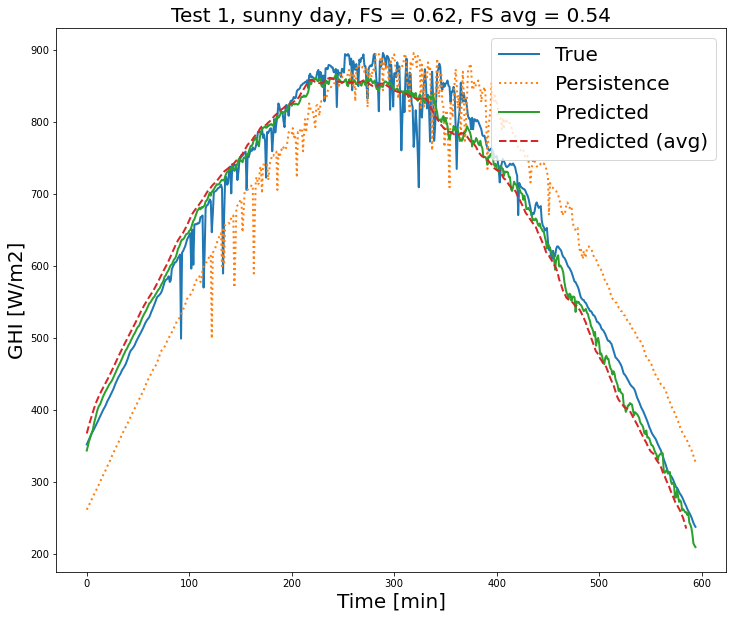

In [94]:
plt.figure(figsize=(12, 10))

plt.plot(y_true, label='True', linewidth=2)
plt.plot(y_pers, label='Persistence', linestyle=':',linewidth=2)
plt.plot(y_test, label='Predicted', linewidth=2)
plt.plot(y_test_avg, label='Predicted (avg)', linestyle='--', linewidth=2)

plt.title('Test 1, sunny day, FS = {:.2f}, FS avg = {:.2f}'.format(FS_test, FS_test_avg), fontsize=20)
plt.xlabel('Time [min]', fontsize=20)
plt.ylabel('GHI [W/m2]', fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.savefig('results/{MODEL_TYPE}/test_1.png'.format(MODEL_TYPE=MODEL_TYPE), dpi=300)
plt.show()

### Test 2

In [95]:
N_AVG = 10
df = df_test_2

test_generator = sequence_img_generator.DataGeneratorGHI_SCNN(df, IMAGE_PATH, **params)
y_test = test_model.predict(test_generator) * df.Target_GHICS.values.reshape(-1, 1)    
y_true = df.Target_GHI.values
y_pers = df.ghi1.values

y_test_avg = moving_average(y_test, n=N_AVG)

rmse_test = np.sqrt(metrics.mean_squared_error(y_true, y_test))
rmse_pers = np.sqrt(metrics.mean_squared_error(y_true, y_pers))
rmse_test_avg = np.sqrt(metrics.mean_squared_error(y_true[:-N_AVG+1], y_test_avg))

FS_test = 1 - (rmse_test / rmse_pers)
FS_test_avg = 1 - (rmse_test_avg / rmse_pers)

584/584 [==============================] - 2s 3ms/step


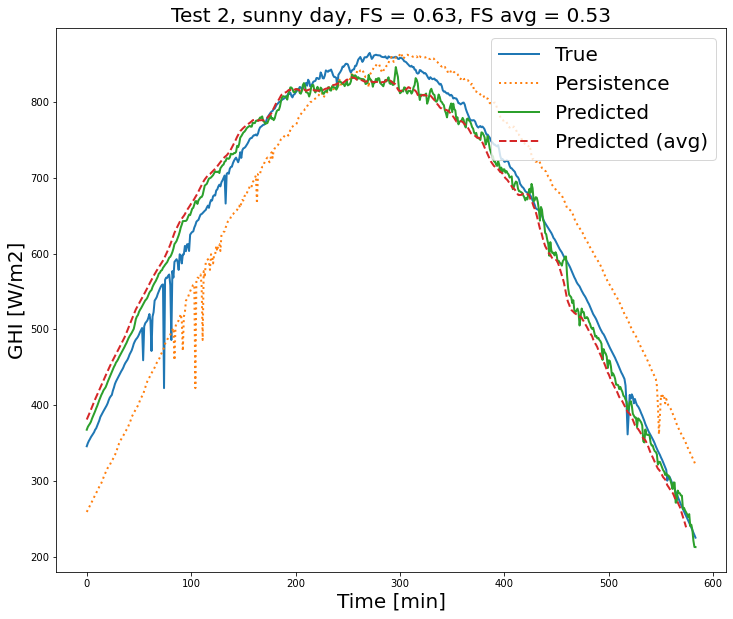

In [96]:
plt.figure(figsize=(12, 10))
plt.plot(y_true, label='True', linewidth=2)
plt.plot(y_pers, label='Persistence', linestyle=':',linewidth=2)
plt.plot(y_test, label='Predicted', linewidth=2)
plt.plot(y_test_avg, label='Predicted (avg)', linestyle='--', linewidth=2)
plt.title('Test 2, sunny day, FS = {:.2f}, FS avg = {:.2f}'.format(FS_test, FS_test_avg), fontsize=20)
plt.xlabel('Time [min]', fontsize=20)
plt.ylabel('GHI [W/m2]', fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.savefig('results/{MODEL_TYPE}/test_2.png'.format(MODEL_TYPE=MODEL_TYPE), dpi=300)
plt.show()

### Test 3

In [97]:
N_AVG = 10
df = df_test_3

test_generator = sequence_img_generator.DataGeneratorGHI_SCNN(df, IMAGE_PATH, **params)
y_test = test_model.predict(test_generator) * df.Target_GHICS.values.reshape(-1, 1)    
y_true = df.Target_GHI.values
y_pers = df.ghi1.values

y_test_avg = moving_average(y_test, n=N_AVG)

rmse_test = np.sqrt(metrics.mean_squared_error(y_true, y_test))
rmse_pers = np.sqrt(metrics.mean_squared_error(y_true, y_pers))
rmse_test_avg = np.sqrt(metrics.mean_squared_error(y_true[:-N_AVG+1], y_test_avg))

FS_test = 1 - (rmse_test / rmse_pers)
FS_test_avg = 1 - (rmse_test_avg / rmse_pers)

575/575 [==============================] - 2s 3ms/step


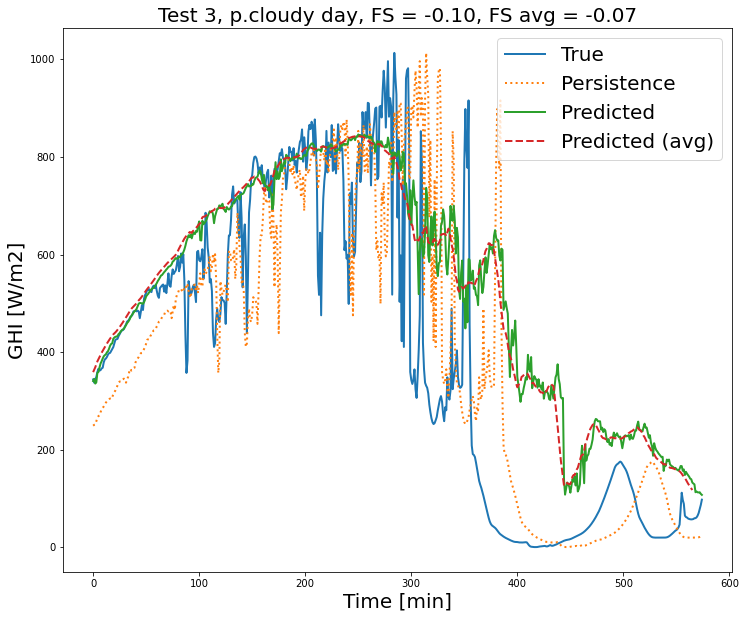

In [98]:
plt.figure(figsize=(12, 10))
plt.plot(y_true, label='True', linewidth=2)
plt.plot(y_pers, label='Persistence', linestyle=':',linewidth=2)
plt.plot(y_test, label='Predicted', linewidth=2)
plt.plot(y_test_avg, label='Predicted (avg)', linestyle='--', linewidth=2)
plt.title('Test 3, p.cloudy day, FS = {:.2f}, FS avg = {:.2f}'.format(FS_test, FS_test_avg), fontsize=20)
plt.xlabel('Time [min]', fontsize=20)
plt.ylabel('GHI [W/m2]', fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.savefig('results/{MODEL_TYPE}/test_3.png'.format(MODEL_TYPE=MODEL_TYPE), dpi=300)
plt.show()

### Test 4

In [99]:
N_AVG = 10
df = df_test_4

test_generator = sequence_img_generator.DataGeneratorGHI_SCNN(df, IMAGE_PATH, **params)
y_test = test_model.predict(test_generator) * df.Target_GHICS.values.reshape(-1, 1)    
y_true = df.Target_GHI.values
y_pers = df.ghi1.values

y_test_avg = moving_average(y_test, n=N_AVG)

rmse_test = np.sqrt(metrics.mean_squared_error(y_true, y_test))
rmse_pers = np.sqrt(metrics.mean_squared_error(y_true, y_pers))
rmse_test_avg = np.sqrt(metrics.mean_squared_error(y_true[:-N_AVG+1], y_test_avg))

FS_test = 1 - (rmse_test / rmse_pers)
FS_test_avg = 1 - (rmse_test_avg / rmse_pers)

573/573 [==============================] - 2s 3ms/step


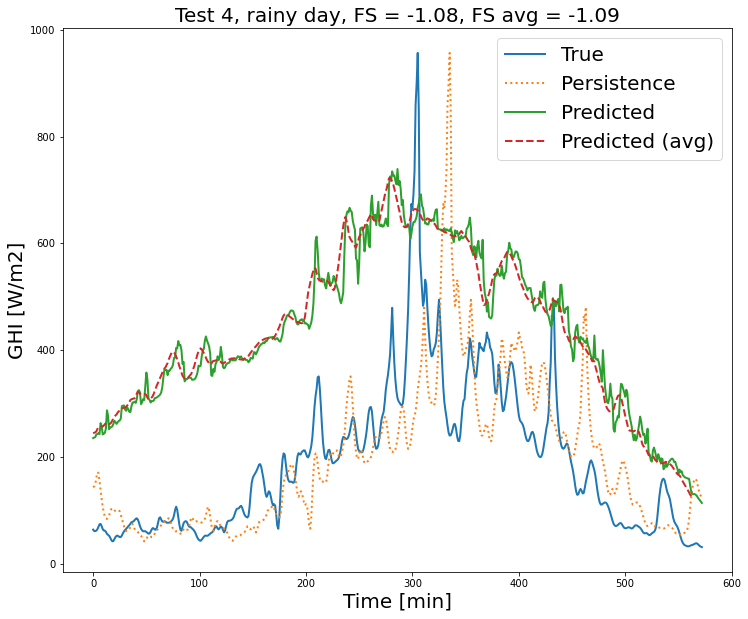

In [100]:
plt.figure(figsize=(12, 10))
plt.plot(y_true, label='True', linewidth=2)
plt.plot(y_pers, label='Persistence', linestyle=':',linewidth=2)
plt.plot(y_test, label='Predicted', linewidth=2)
plt.plot(y_test_avg, label='Predicted (avg)', linestyle='--', linewidth=2)
plt.title('Test 4, rainy day, FS = {:.2f}, FS avg = {:.2f}'.format(FS_test, FS_test_avg), fontsize=20)
plt.xlabel('Time [min]', fontsize=20)
plt.ylabel('GHI [W/m2]', fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.savefig('results/{MODEL_TYPE}/test_4.png'.format(MODEL_TYPE=MODEL_TYPE), dpi=300)
plt.show()

### Test 5

In [101]:
N_AVG = 10
df = df_test_5

test_generator = sequence_img_generator.DataGeneratorGHI_SCNN(df, IMAGE_PATH, **params)
y_test = test_model.predict(test_generator) * df.Target_GHICS.values.reshape(-1, 1)    
y_true = df.Target_GHI.values
y_pers = df.ghi1.values

y_test_avg = moving_average(y_test, n=N_AVG)

rmse_test = np.sqrt(metrics.mean_squared_error(y_true, y_test))
rmse_pers = np.sqrt(metrics.mean_squared_error(y_true, y_pers))
rmse_test_avg = np.sqrt(metrics.mean_squared_error(y_true[:-N_AVG+1], y_test_avg))

FS_test = 1 - (rmse_test / rmse_pers)
FS_test_avg = 1 - (rmse_test_avg / rmse_pers)

567/567 [==============================] - 2s 3ms/step


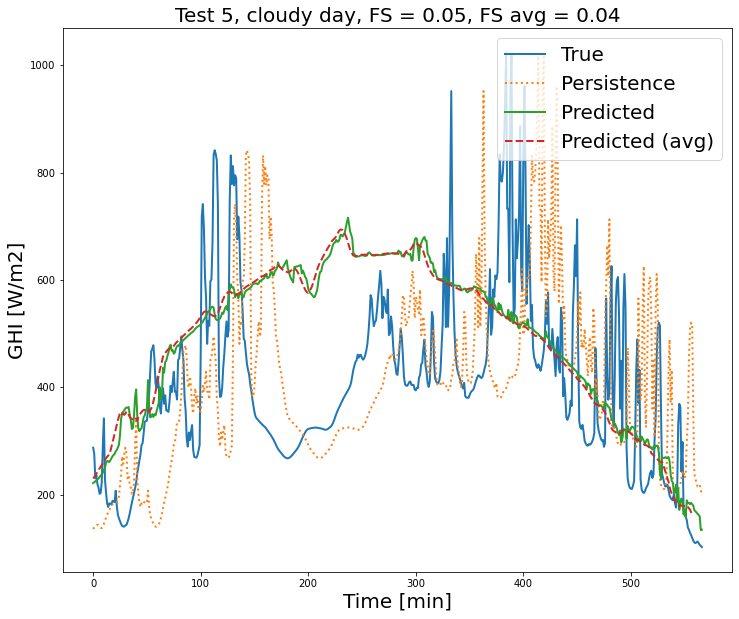

In [102]:
plt.figure(figsize=(12, 10))
plt.plot(y_true, label='True', linewidth=2)
plt.plot(y_pers, label='Persistence', linestyle=':',linewidth=2)
plt.plot(y_test, label='Predicted', linewidth=2)
plt.plot(y_test_avg, label='Predicted (avg)', linestyle='--', linewidth=2)
plt.title('Test 5, cloudy day, FS = {:.2f}, FS avg = {:.2f}'.format(FS_test, FS_test_avg), fontsize=20)
plt.xlabel('Time [min]', fontsize=20)
plt.ylabel('GHI [W/m2]', fontsize=20)

plt.legend(fontsize=20, loc='upper right')
plt.savefig('results/{MODEL_TYPE}/test_5.png'.format(MODEL_TYPE=MODEL_TYPE), dpi=300)
plt.show()

In [103]:
# mlflow.set_tracking_uri("sqlite:///mlflow.db")
# logged_model = 'runs:/d7855d74a3bd400fa1c1a6052822640e/SCNN_small_0.0003_mean_squared_error'

# # Load model as a PyFuncModel.
# loaded_model = mlflow.tensorflow.load_model(logged_model)